Todo : 
- implement UCB1
- check if there are other algorithms
- find good experiments to compare algorithms (Penser à des experiences ou le meilleur bras n'est pas evident à trouver/ passe au dessus qu'a la fin par ex)
- reproduce experiment of https://arxiv.org/pdf/1506.03271.pdf (Section 4)

3 algorithms : Exp3, Exp3.P, Exp3-IX

# Exp-3 algorithms

ref :  https://jeremykun.com/2013/11/08/adversarial-bandits-and-the-exp3-algorithm/

https://arxiv.org/pdf/1506.03271.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# need to define class arm (cf TD2)
class Arm():
    """ 
    Defines an arm with arbitrary finite sequence of reward
    """
    def __init__(self, rewards_sequence):
        self.rewards = rewards_sequence
    
    def sample(self, t):
        return self.rewards[t]

In [3]:
class bernoulliArm():
    def __init__(self, mean):
        self.mean = mean
    
    def sample(self, t):
        return np.random.binomial(p=self.mean, n=1)

In [4]:
class evolvingBernoulliArm():
    def __init__(self, means, switching_time):
        self.means = means
        self.switching_time = switching_time
    
    def sample(self, t):
        if t <= self.switching_time:
            return np.random.binomial(p=self.means[0], n=1)
        else:
            return np.random.binomial(p=self.means[1], n=1)

In [71]:
def exp3(MAB, T, gamma=0.05, Exp3P=False, alpha=0):
    """
    Exp3 algorithm as in Auer et al. (2001)
    MAB: list of arms from Arm class
    T: time horizon
    gamma: exploration parameter for Exp3
    """
    
    K = len(MAB) # number of arms
    
    # initialize rewards estimation
    
    R = np.zeros(K)
    if Exp3P:
        bs = alpha * np.sqrt(T * K) * np.ones(K)
    
    # History of rewards and weights
    reward_hist = []

    
    for t in range(T):
        # Set probabilities of drawing each arm
        if  not Exp3P:
            p = (1 - gamma) * np.exp(gamma * (R - np.min(R)) / K) /  np.sum(np.exp(gamma * (R - np.min(R)) / K)) + gamma / K
        else:
            p = (1-gamma) * np.exp(gamma / (3 * K) * ((R +bs) - np.min(R + bs))) / np.sum(np.exp(gamma / (3 * K) * ((R +bs) - np.min(R + bs)))) + gamma / K
        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p) 
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward
        estimated_reward = drawn_reward / p[drawn_index] 
        
        #update rewards estimation 
        R[drawn_index] += drawn_reward / p[drawn_index]
        
        if Exp3P:
            bs += alpha / (np.sqrt(K * T) * p)
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        
    return reward_hist, R

In [6]:
def exp3_IX(MAB, T, eta, gamma):
    """
    Exp3-IX algorithm as in Explore no more (Neu)
    MAB: list of arms from Arm class
    T: the time horizon
    eta: learning rate
    gamma: implicit exploration parameter
    """
    
    K = len(MAB) # number of arms
    W = np.ones(K) # initialize weights
    
    # History of rewards and weights
    reward_hist = []
    
    R = np.zeros(K) #estimated rewards
    
    for t in range(T):
        
        # Set probabilities of drawing each arm

        p = np.exp(eta * (R - np.max(R))) / np.sum(np.exp(eta * (R - np.max(R))))

        # Draw arm index
        drawn_index = np.random.choice(a=K, p=p)
        
        # Draw corresponding reward
        drawn_reward = MAB[drawn_index].sample(t) 
        
        # Compute estimated reward with implicit exploration
        estimated_reward = drawn_reward/(p[drawn_index] + gamma) 
        
        R[drawn_index] += estimated_reward #update rewards estimation
        
        # Save obtained reward and weights
        reward_hist.append(drawn_reward) 
        
    return reward_hist, R

In [7]:
def UCB1(MAB, T, rho):
    n_iter = 0
    K = len(MAB)
    means_empirical = np.array([0. for i in range(K)])
    number_arms_draw = np.array([1 for i in range(K)])
    rew_draws = [[], []]

    # initialisation phases
    while n_iter < min(K, T):
        reward = MAB[n_iter].sample(n_iter)
        rew_draws[0].append(reward)
        rew_draws[1].append(n_iter)
        means_empirical[n_iter] += reward
        n_iter += 1
    # UCB
    while n_iter < T:
        i = np.argmax(means_empirical + rho *
                      (np.log(n_iter + 1) / (2 * number_arms_draw))**2)
        # drawing
        reward = MAB[i].sample(n_iter)
        rew_draws[0].append(reward)
        rew_draws[1].append(i)
        # update statistics
        number_arms_draw[i] += 1
        means_empirical[i] += ((reward - means_empirical[i]) / (number_arms_draw[i]))
        # increment
        n_iter += 1
    return rew_draws

In [8]:
# we define gaussian trajectories normalized to lie in [0, 1]

def gaussian_traj(T):
    gp = np.cumsum(np.random.normal(0, 2, T))

    # normalization (to have rewards in [0, 1]) :
    gp += np.abs(min(gp))
    gp /= max(gp)
    return(gp)

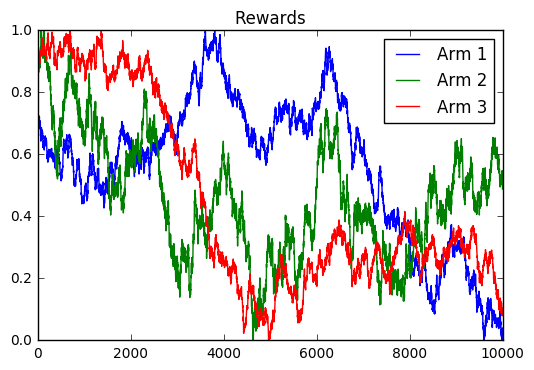

In [49]:
T = 10000

arm1 = Arm(gaussian_traj(T))
arm2 = Arm(gaussian_traj(T))
arm3 = Arm(gaussian_traj(T))

MAB = [arm1, arm2, arm3]

plt.plot(arm1.rewards)
plt.plot(arm2.rewards)
plt.plot(arm3.rewards)
plt.legend(['Arm 1', 'Arm 2', 'Arm 3'])
plt.title('Rewards')

In [50]:
n_iter = 10
rews_exp3, rews_exp3P, rews_IX= [np.zeros((n_iter, T)) for _ in range(3)]


for i in range(n_iter):
    rew, _ = exp3(MAB, T, gamma=0.05, Exp3P=False, alpha=0)
    rews_exp3[i] = rew
    rew_P, _ = exp3(MAB, T, gamma=0.05, Exp3P=True, alpha=0.1)
    rews_exp3P[i] = rew_P
    rew_IX, _ = exp3_IX(MAB, T, eta=0.5, gamma=0.5)
    rews_IX[i] = rew_IX

rew_UCB, _ = UCB1(MAB, T, rho=0.2)

rew= np.mean(rews_exp3, axis=0)
rew_P = np.mean(rews_exp3P, axis=0)
rew_IX = np.mean(rews_IX, axis=0)

arm1_cumsum = np.cumsum(arm1.rewards)
arm2_cumsum = np.cumsum(arm2.rewards)
arm3_cumsum = np.cumsum(arm3.rewards)
exp3_cumsum = np.cumsum(rew)
exp3_P_cumsum = np.cumsum(rew_P)
exp3_IX_cumsum = np.cumsum(rew_IX)
UCB_cumsum = np.cumsum(rew_UCB)

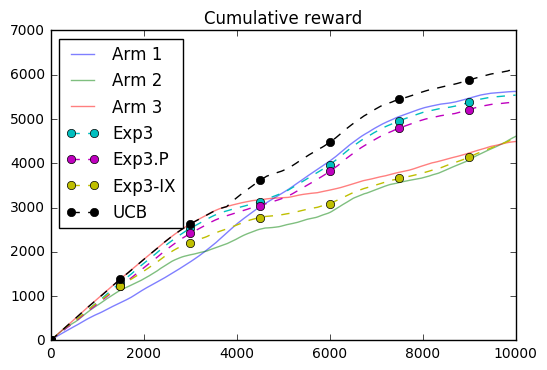

In [51]:
plt.plot(np.cumsum(arm1.rewards), alpha=0.5)
plt.plot(np.cumsum(arm2.rewards), alpha=0.5)
plt.plot(np.cumsum(arm3.rewards), alpha=0.5)

plt.plot(exp3_cumsum, '--o', markevery=1500)

plt.plot(exp3_P_cumsum, '--o', markevery=1500)
plt.plot(exp3_IX_cumsum, '--o', markevery=1500)
plt.plot(UCB_cumsum, '--o', markevery=1500)

plt.legend(['Arm 1', 'Arm 2', 'Arm 3', 'Exp3', 'Exp3.P', 'Exp3-IX', 'UCB'], loc="upper left")
plt.title("Cumulative reward")

In [36]:
best_action_rew = np.zeros(T)
for t in range(T):
    best_action_rew[t] = max(arm1_cumsum[t], arm2_cumsum[t], arm3_cumsum[t])

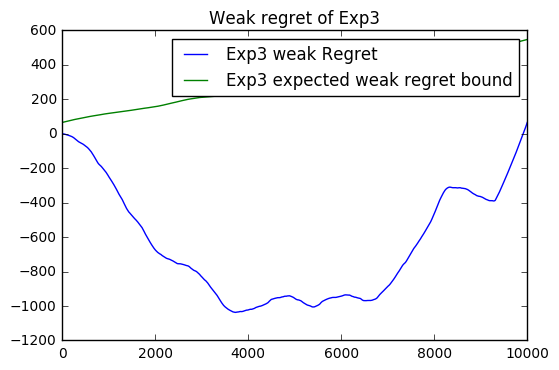

In [58]:
plt.plot(best_action_rew - exp3_cumsum, label="Exp3 weak Regret")
gamma = 0.05
plt.plot((np.exp(1) - 1) *  gamma * best_action_rew + len(MAB) * np.log(len(MAB)) / gamma, label="Exp3 expected weak regret bound")

plt.title("Weak regret of Exp3")
plt.legend()

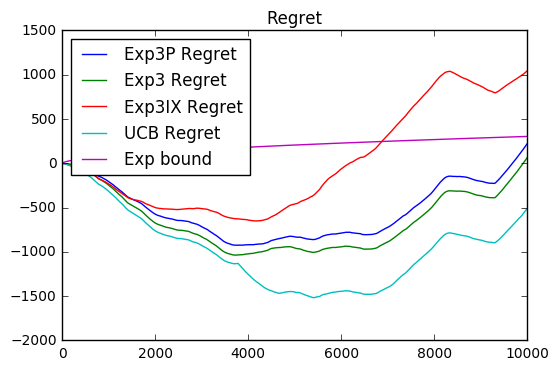

In [53]:
plt.plot(best_action_rew - exp3_P_cumsum, label="Exp3P Regret")
plt.plot(best_action_rew - exp3_cumsum, label="Exp3 Regret")
plt.plot(best_action_rew - exp3_IX_cumsum, label="Exp3IX Regret")
plt.plot(best_action_rew - UCB_cumsum, label="UCB Regret")
plt.title('Regret')

lin = [np.sqrt(t * log(t)) for t in range(1, T)]
plt.plot(lin, label="Exp bound") 

plt.legend(loc="upper left")

# Exp3-IX expriment

Ref : https://arxiv.org/pdf/1506.03271.pdf (Section 4)

10-arm bandit problem where
all losses are independent draws of Bernoulli random variables. 

The mean rewards of arms 1 through 8 are 0.5

The mean reward of arm 9 is $0.5 + \delta$ for all rounds $t = 1, 2, . . . , T$. 

The mean rewards of
arm 10 are changing over time: for rounds $t \leq \frac{T}{2}$, the mean is $0.5 - \delta$, and $0.5 + 4\delta$ afterwards.

/!\ We consider rewards instead of losses (opposite to the article) 

$\beta = \frac{\gamma}{K} = \frac{\eta}{20}$ ou $\beta = \eta$ ???

In [39]:
T = 10000
delta = 0.1
MAB_IX = [bernoulliArm(0.5) for i in range(8)]
MAB_IX.append(bernoulliArm(0.5 + delta))
MAB_IX.append(evolvingBernoulliArm([0.5 - delta, 0.5 + 4*delta], T/2))

In [72]:
R_T = []
R_T2 = []

T = 10000
T2 = 5000
for eta in np.linspace(10e-4, 1, 50):
    print(eta)
    rew, _ = exp3(MAB_IX, T, eta)

    rew_P, weights = exp3(MAB_IX, T, Exp3P=True, gamma=eta)
    rew_IX, _ = exp3_IX(MAB_IX, T, eta, eta/2)
    
    exp3_T2, exp3_P_T2, exp3_IX_T2 = np.sum(rew[: T2]), np.sum(rew_P[: T2]), np.sum(rew_IX[: T2])
    
    exp3_T, exp3_P_T, exp3_IX_T = exp3_T2 + np.sum(rew[T2:]), exp3_P_T2 + np.sum(rew_P[T2 :]), exp3_IX_T2 + np.sum(rew_IX[T2:])
    
    
    R_T2.append([exp3_T2, exp3_P_T2, exp3_IX_T2])
    R_T.append([exp3_T, exp3_P_T, exp3_IX_T])

rew_UCB, _ = UCB1(MAB, T, rho=0.2)
UCB_cumsum = np.cumsum(rew_UCB)

0.001
0.021387755102
0.0417755102041
0.0621632653061
0.0825510204082
0.10293877551
0.123326530612
0.143714285714
0.164102040816
0.184489795918
0.20487755102
0.225265306122
0.245653061224
0.266040816327
0.286428571429
0.306816326531
0.327204081633
0.347591836735
0.367979591837
0.388367346939
0.408755102041
0.429142857143
0.449530612245
0.469918367347
0.490306122449
0.510693877551
0.531081632653
0.551469387755
0.571857142857
0.592244897959
0.612632653061
0.633020408163
0.653408163265
0.673795918367
0.694183673469
0.714571428571
0.734959183673
0.755346938776
0.775734693878
0.79612244898
0.816510204082
0.836897959184
0.857285714286
0.877673469388
0.89806122449
0.918448979592
0.938836734694
0.959224489796
0.979612244898
1.0


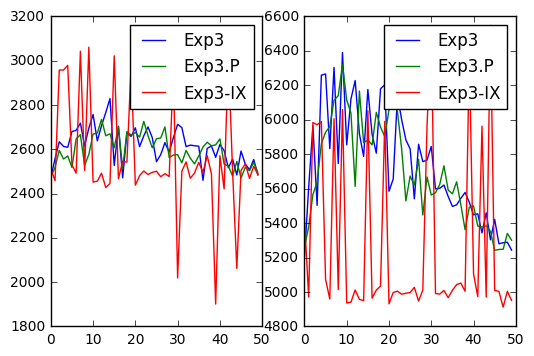

In [79]:
RT2 = np.array(R_T2)
RT = np.array(R_T)

plt.subplot(1, 2, 1)
plt.plot(RT2[:, 0], label="Exp3")
plt.plot(RT2[:, 1], label="Exp3.P")
plt.plot(RT2[:, 2], label="Exp3-IX")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(RT[:, 0], label="Exp3")
plt.plot(RT[:, 1], label="Exp3.P")
plt.plot(RT[:, 2], label="Exp3-IX")
plt.legend()

In [ ]:

plt.plot(exp3_cumsum)
plt.plot(exp3_P_cumsum)
plt.plot(exp3_IX_cumsum)
plt.plot(UCB_cumsum)
plt.legend(['Exp3', 'Exp3.P', 'Exp3-IX', "UCB"], loc="upper left")
plt.title("Cumulative reward")